# Flow Neighborhoods

> Calculate the **directed neighbors** of each data points based on the flows at these points

In [ ]:
# default_exp data_processing
# hide
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FlowNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

We introduce the notion of flow neighborhood $N_v(i)$ of data point $x_i$, where $k \in N_v(i)$ if $x_k$ is close to $x_i$ based on euclidean disatnce and the flow $\vec{v_i}$ at $x_i$ points towards the location of $x_k$. We have qualified these 2 qualities using our Flashlight Kernel. So the flow neighborhood $N_v(i)$ can be simply calculated as the `n_neighbors` data points (other than $x_i$ itself) with the highest (asymetric) affinity to $x_i$.

The function `directed_neighbors` returns a tensor of directed edge index where $(i,k)$ is an edge if $k \in N_v(i)$, i.e. $x_k$ is in the flow neighborhood of $x_i$, or $x_k$ is one of the `n_neighbors` data points with the highest affinity to $x_i$. 

In [ ]:
# export
def directed_neighbors(num_nodes, P_graph, n_neighbors=5):
    # remove self loop
    P_graph = P_graph - torch.eye(num_nodes).to(P_graph.device)
    # return k nearest neighbor indices
    _, neighbors = torch.topk(P_graph, n_neighbors)
    # convert to edge_index format
    row = torch.arange(num_nodes).repeat_interleave(n_neighbors).to(P_graph.device)
    col = neighbors.flatten().to(P_graph.device)
    return torch.stack((row, col))

We test `directed_neighbors` on a simple circle. We would expect the flow neighborhood of any point to be the next `n_neighbors` points in the circle.

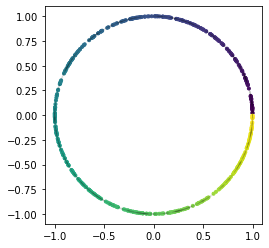

In [ ]:
# hide_input
from FlowNet.datasets import directed_circle, plot_directed_2d
import torch
X, flows, labels = directed_circle()
plot_directed_2d(X, flows, labels)

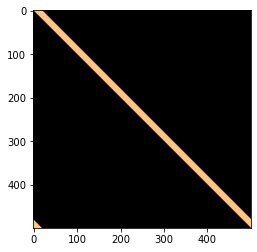

In [ ]:
# collapse
from FlowNet.data_processing import affinity_matrix_from_pointset_to_pointset
from FlowNet.datasets import visualize_edge_index
import torch

X = torch.tensor(X).float()
flows = torch.tensor(flows).float()

P_graph = affinity_matrix_from_pointset_to_pointset(X, X, flows, sigma=1, flow_strength=1)

neighbors = directed_neighbors(X.shape[0], P_graph, n_neighbors=20)
visualize_edge_index(neighbors)